In [1]:
import sys
import yt.units as u
import numpy
import numpy as np
import matplotlib.pyplot as plt
import pyximport

from dengo.chemical_network import \
    ChemicalNetwork, \
    reaction_registry, \
    cooling_registry, species_registry
import dengo.primordial_rates, dengo.primordial_cooling
from dengo.chemistry_constants import tiny, kboltz, mh
import h5py
import os
import numpy
import h5py

os.environ['HDF5_DIR'] = '/home/kwoksun2/anaconda2/'

/home/kwoksun2/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


 using cli
 using CLI for selections


In [2]:
?dengo.chemical_network

Type:        module
String form: <module 'dengo.chemical_network' from '/home/kwoksun2/dengo-git/dengo/chemical_network.py'>
File:        ~/dengo-git/dengo/chemical_network.py
Docstring:  
Author: Matthew Turk <matthewturk@gmail.com>
Affiliation: Columbia University
Homepage: http://yt.enzotools.org/
License:
  Copyright (C) 2012 Matthew Turk.  All Rights Reserved.

  This file is part of the dengo package.

  This file is free software; you can redistribute it and/or modify
  it under the terms of the GNU General Public License as published by
  the Free Software Foundation; either version 3 of the License, or
  (at your option) any later version.

  This program is distributed in the hope that it will be useful,
  but WITHOUT ANY WARRANTY; without even the implied warranty of
  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
  GNU General Public License for more details.

  You should have received a copy of the GNU General Public License
  along with this program.  If 

In [3]:
def Init_values(temperature, density, n_species = 9, cooling=True, size=10):
    """ Create a initial value dictionary,
        for a given temperature, density, number of species
    Args:
        temperature -- in Kelvin
        density     -- in amu / cm**3
        n_species   -- number of species (6/9)
        cooling

    Returns:
        init_values: initial value dictionary with
                     self-consistent energy/ electron density
        primordial : chemical_network classes

    """

    # initialize and setup the network
    dengo.primordial_rates.setup_primordial()
    primordial = ChemicalNetwork()
    primordial.threebody = 4
    primordial.include_binding_energy = 0
    
    if n_species == 9:
        for i in range(22):
            try:
                primordial.add_reaction("k{0:02d}".format(i+1))
            except:
                pass
    else:
        for i in range(6):
            try:
                primordial.add_reaction("k{0:02d}".format(i+1))
            except:
                pass

    # the temperature array required to interpolates the rates
    primordial.init_temperature((1e0, 1e5))

    tiny = 1.0e-10

    # init_array are is in fractional abundances
    init_values = dict()
    density = numpy.array([density])*numpy.ones((size))
    if n_species == 6:
        # 6-species model
        init_values["He_1"]    = density * (1.0 - 0.76)
        init_values["He_2"]    = np.array([tiny])
        init_values["He_3"]    = np.array([tiny])
        init_values["H_1"]     = density *  (0.76)
        init_values['H_2']     = np.array([tiny]) 
    else:
        # 9-species model
        init_values["He_1"]    = density * (1.0 - 0.76) 
        init_values["He_2"]    = density *np.array([tiny])
        init_values["He_3"]    = density *np.array([tiny])
        init_values["H_1"]     = density *  (0.76)
        init_values['H_2']     = density *np.array([tiny])

        init_values["H_m0"]    = density *np.array([tiny])
        init_values["H2_1"]    = density *np.array([tiny])
        init_values["H2_2"]    = density *np.array([tiny])

    # now everything in mass density
    init_values['de'] = primordial.calculate_free_electrons(init_values)
    # one signle value: again mass density
    init_values['density'] = primordial.calculate_total_density(init_values)

    num_den = {}
    for sp in primordial.required_species:
        try:
            num_den[sp.name] = init_values[sp.name]/ sp.weight
        except:
            pass

    # set up initial temperatures values used to define ge
    init_values['T'] = numpy.array([temperature])*numpy.ones((size))
    ge_array = numpy.ones((size))
    init_values['ge'] = ge_array
    
    # calculate gammaH2
    
    for i in range(size):
        
        temperature = init_values['T'][i]
        x = 6100.0/temperature
        expx = numpy.exp(x)
        gammaH2 = 2.0 / (5.0 + 2.0*x*x*expx / (expx - 1 )**2.0 ) + 1

        rs = primordial.required_species
        H2_1_sp = list(rs)[0]
        gammaH2 = primordial.species_gamma(H2_1_sp,name=False, temp=True).subs({'T':temperature})

        new_num_den = {}
        for ele in num_den.keys():
            new_num_den[ele] = num_den[ele][i]
        
        gamma_factor = primordial.gamma_factor().subs(new_num_den).subs({'gammaH2_2': gammaH2 ,'gammaH2_1': gammaH2 , 'gamma': 5./3.,'T': temperature })

        ge  = ((temperature *  kboltz) *gamma_factor
                             / (init_values['density'][i] * mh  ))

        
        T = init_values['density']*ge*mh / kboltz / gamma_factor
        init_values['ge'][i] = numpy.float64(ge)
    print(ge)
    if cooling:
        for cooling_action in cooling_registry:
            k = cooling_registry[cooling_action]
            if (k.species).issubset( primordial.required_species ):
                print("adding cooling: {}".format(k.name) )
                primordial.add_cooling(cooling_action)
    return init_values, primordial

In [4]:
density = 1e14
initial_temperature = 3000.0
final_time = (1.0 / (u.G * u.mass_hydrogen * u.cm**-3 * density)**0.5).in_cgs().v



init, primordial = Init_values(initial_temperature, 
                               density, n_species = 9, 
                               cooling=True,size=1)
primordial.stop_time = final_time


solver_name = "cvklu"

# solver tempelate are organized into different folders
# cv/sundials_CVDls is the latest one
# and it has to be used together with "initialize_cvode_solver.C"

primordial.write_solver(solver_name, output_dir = ".",
    solver_template = "cv_omp/sundials_CVDls",
    ode_solver_source = "initialize_cvode_solver.C",
    init_values=init,
    input_is_number=False)

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

/home/kwoksun2/dengo-git/dengo/primordial_cooling.py:325: RuntimeWarning: overflow encountered in power
  + 70.609154 * lt3[_i2] **8)
/home/kwoksun2/dengo-git/dengo/primordial_cooling.py:349: RuntimeWarning: overflow encountered in power
  + 1.8161874 * lt3**8)


In [5]:
import pyximport
pyximport.install(setup_args={"include_dirs":np.get_include()},
                      reload_support=True, inplace=True)


cvklu_run = pyximport.load_module("cvklu_run",
                            "cvklu_solver_run.pyx",
                            build_inplace = True, pyxbuild_dir = "_dengo_temp")


Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

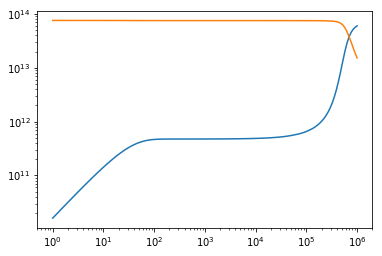

In [6]:
init, primordial = Init_values(initial_temperature, 
                               density, n_species = 9, 
                               cooling=True,size=1)
rv, rv_int_sundials = cvklu_run.run_cvklu(init, 1e6, niter=1e6)
t = rv_int_sundials['t']
H2_1 = rv_int_sundials['H2_1']
H_1 = rv_int_sundials['H_1']

flag = rv_int_sundials['successful']

plt.loglog(t[flag], H2_1[0][flag])
plt.loglog(t[flag], H_1[0][flag])
plt.show()

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

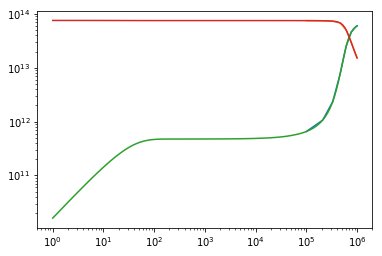

In [7]:
init, primordial = Init_values(initial_temperature, 
                               density, n_species = 9, 
                               cooling=True,size=1)
rv, rv_int_sundials10 = cvklu_run.run_cvklu(init, 1e6, niter=1e1)

t_10 = rv_int_sundials10['t']
H2_1_10 = rv_int_sundials10['H2_1']
H_1_10 = rv_int_sundials10['H_1']

flag_10 = rv_int_sundials10['successful']

plt.loglog(t_10[flag_10], H2_1_10[0][flag_10])
plt.loglog(t_10[flag_10], H_1_10[0][flag_10])

plt.loglog(t[flag], H2_1[0][flag])
plt.loglog(t[flag], H_1[0][flag])
plt.show()




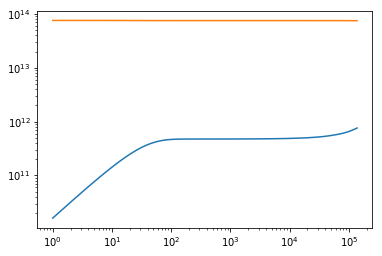

In [8]:
t = rv_int_sundials['t']
H2_1 = rv_int_sundials['H2_1']
H_1 = rv_int_sundials['H_1']

plt.loglog(t[:100], H2_1[0][:100])
plt.loglog(t[:100], H_1[0][:100])
plt.show()

In [42]:
rv_int_sundials['t']

array([1.  , 2.1 , 3.31, ..., 0.  , 0.  , 0.  ])

In [44]:
density = 1e14
initial_temperature = 3000.0
final_time = (1.0 / (u.G * u.mass_hydrogen * u.cm**-3 * density)**0.5).in_cgs().v



init, primordial = Init_values(initial_temperature, 
                               density, n_species = 9, 
                               cooling=True,size=1)

# for sp in primordial.required_species:
#     if sp.name not in primordial.skip_weight:
#         init[sp.name] *= mh
#     elif sp.name == 'de':
#         init[sp.name] *= mh

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

(Species: H2_1, gammaH2)
(Species: H2_2, gammaH2)
(Species: ge, gamma)
(Species: He_1, gamma)
(Species: H_m0, gamma)
(Species: He_3, gamma)
(Species: He_2, gamma)
(Species: H_1, gamma)
(Species: de, gamma)
(Species: H_2, gamma)
